# Case study 1
## Tesla stock prediction 



In [2]:
import numpy as np
import pandas as pd
from pycaret.regression import *
import pandas as pd
import yfinance as yf


In [3]:
# Download additional stock data, which is correlated to Tesla stock, after research we found that NASDAQ is very correlated

tesla_df = yf.download(['TSLA'], 
                      start='2013-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()
nasdq_df = yf.download(['^IXIC'], 
                      start='2013-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()
events = pd.read_excel('tesla_tweets.xlsx', sheet_name='tesla_tweets')[['Date', 'stock%']]
events = events[events['stock%']!=0]
nasdq_df.columns = ['Date', 'NSDQ-Open', 'NSDQ-High', 'NSDQ-Low', 'NSDQ-Close', 'NSDQ-Adj Close', 'NSDQ-Volume']
tesla_df.columns = ['Date', 'tesla-Open', 'tesla-High', 'tesla-Low', 'tesla-Close', 'tesla-Adj Close', 'tesla-Volume']
event_tesla_merge = pd.merge(tesla_df, events, how='left', on='Date')
data = pd.merge(event_tesla_merge, nasdq_df, how='left', on='Date')
data['stock%']=data['stock%'].fillna(0)

In [4]:
def date_extraction(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['year'] = pd.DatetimeIndex(dataset['Date']).year
    dataset['month'] = pd.DatetimeIndex(dataset['Date']).month
    dataset['day_of_year'] = dataset.Date.dt.dayofyear
    dataset['day_of_week'] = dataset.Date.dt.dayofweek

    # dataset.drop(columns='Date', inplace=True)
date_extraction(data)




# 1. Initial Data Understanding
Here, we get to know our data and try to figure out next steps for modelling.

A goal in this step is to get to know what types of data cleaning, preparation and encoding we need to do in order to prepare our data for inclusion in a model.

Since we are predicting price, this is a supervised regression problem.

## visualization


In [5]:

# plot the data and MA
import plotly.express as px
fig = px.line(data, x="Date", y=["tesla-Close", "NSDQ-Close"], template = 'plotly_dark')
fig.show()


### running preprocessing on our data

# Model pipeline


In [6]:
# split data into train-test set
train = data[data['Date'] < '2021-06-15'][['year', 'month', 'day_of_year', 'day_of_week','tesla-Close']]
test = data[data['Date'] >= '2021-06-15'][['year', 'month', 'day_of_year', 'day_of_week','tesla-Close']]
# check shape
train.shape, test.shape


((2127, 5), (11, 5))

In [7]:
train.columns

Index(['year', 'month', 'day_of_year', 'day_of_week', 'tesla-Close'], dtype='object')

In [8]:
# import the regression module
from pycaret.regression import *
# initialize setup
s = setup(data = train, train_size=0.8, test_data = test, target = 'tesla-Close', 
    fold_strategy = 'timeseries', numeric_features = ['year', 'month', 'day_of_year', 'day_of_week'], 
    feature_interaction=True, 
    ignore_low_variance=True,
    remove_multicollinearity=True, multicollinearity_threshold=0.9, 
    fold = 3, transform_target = True, session_id = 123)


    

,Description,Value
0,session_id,123
1,Target,tesla-Close
2,Original Data,"(2127, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2127, 6)"


In [9]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,89.5312,43082.1348,126.8067,-2.0197,0.6462,0.3123,0.0233
lightgbm,Light Gradient Boosting Machine,89.5732,43118.5238,126.8610,-2.0534,0.6465,0.3112,0.2433
xgboost,Extreme Gradient Boosting,89.6122,43080.9363,126.8992,-2.1031,0.6480,0.3134,0.5000
rf,Random Forest Regressor,89.9567,43098.1389,127.2385,-2.3650,0.6546,0.3187,0.2800
et,Extra Trees Regressor,90.1802,43578.5768,127.6413,-2.1612,0.6612,0.3099,0.2433
gbr,Gradient Boosting Regressor,90.3203,43750.7856,127.8710,-2.1834,0.6666,0.3076,0.1533
ada,AdaBoost Regressor,90.5486,42869.4703,127.5591,-3.0877,0.6607,0.3315,0.0733
catboost,CatBoost Regressor,91.1946,43496.3866,128.8753,-3.5356,0.6893,0.3255,1.8767
omp,Orthogonal Matching Pursuit,91.2408,40616.8884,128.2976,-8.1070,0.6695,0.4251,2.3400
en,Elastic Net,92.4029,42330.7545,129.4867,-5.2095,0.7201,0.3769,0.0200


In [16]:
future_dates = pd.date_range(start = '2021-06-15', end = '2021-06-29', freq = 'D')
future_df = pd.DataFrame()
future_df['month'] = [i.month for i in future_dates]
future_df['year'] = [i.year for i in future_dates] 
future_df['day_of_week'] = [i.dayofweek for i in future_dates]
future_df['day_of_year'] = [i.dayofyear for i in future_dates]

In [17]:
xgboost = create_model('xgboost', fold = 10)
final_best = finalize_model(xgboost)
predictions_future = predict_model(xgboost, data=future_df)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,22.1544,637.2410,25.2436,-11.7469,1.1022,0.5563
1,5.4029,42.0964,6.4882,-0.6697,0.1463,0.1182
2,4.5799,29.6263,5.4430,-0.7082,0.1121,0.0950
3,6.6143,54.3864,7.3747,-1.7069,0.1636,0.1582
4,13.9693,289.8435,17.0248,-1.1662,0.3195,0.2266
5,7.9148,105.2381,10.2586,-3.0487,0.1708,0.1213
6,6.8581,72.5214,8.5160,-1.2110,0.1316,0.1136
7,9.4374,143.7295,11.9887,-1.2487,0.2224,0.2061
8,129.5731,27609.8398,166.1621,-1.8537,1.2707,0.6053
9,364.9974,200738.2344,448.0382,-8.7161,1.2844,0.5248


In [18]:
pd.merge(test, predictions_future, how='inner', on=['year', 'month', 'day_of_week', 'day_of_year'])[['tesla-Close', 'Label']]

,tesla-Close,Label
0,599.359985,622.507507
1,604.869995,608.362000
2,616.599976,604.838440
3,623.309998,609.125366
4,620.830017,617.984131
5,623.710022,617.638672
6,656.570007,607.321228
7,679.820007,597.894531
8,671.869995,582.942200
9,688.719971,587.937378


(500.0, 800.0)

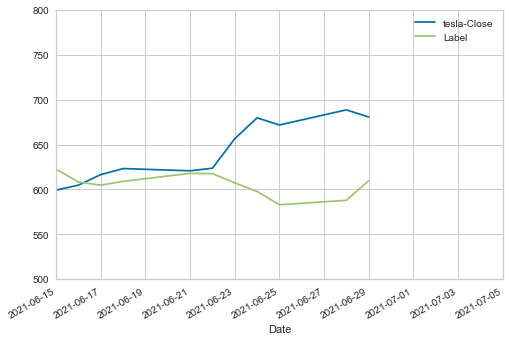

In [21]:
import matplotlib.pyplot as plt

total_data_w_test = pd.merge(data, predictions_future, how='outer', on=['year', 'month', 'day_of_week', 'day_of_year'])
total_data_w_test.plot(x='Date', y=['tesla-Close', 'Label'])
plt.xlim(['2021-6-15', '2021-07-05'])
plt.ylim([500, 800])

In [23]:
# line plot
import plotly.graph_objects as go
fig = go.Figure(px.line(total_data_w_test, x='Date', y=["tesla-Close", "Label"], template = 'plotly_dark'), layout_yaxis_range=[500,1000], layout_xaxis_range=['2021-06-01', '2021-07-05'])
# add a vertical rectange for test-set separation
fig.add_vrect(x0='2021-6-15', x1='2021-06-29', fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

# Feature importance


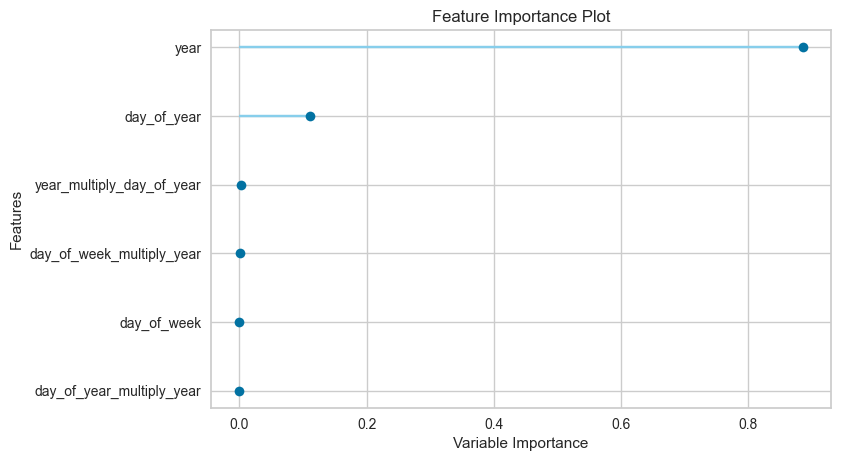

In [123]:
plot_model(xgboost, 'feature')